<a href="https://colab.research.google.com/github/SaketMunda/clip-usage-101/blob/master/clip_introduction_to_connect_image_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to [CLIP](https://openai.com/blog/clip/), a research by [OpenAI](https://openai.com/)

A neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task.

[Github](https://github.com/openai/CLIP)

## Goal of this Colab

This is a self-contained notebook that shows how to download and run CLIP model, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

## Preparation

Make sure you're running on GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2m1pku4c
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-2m1pku4c
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=8d986725fb834dbf720b7e0164b0b6b966335cea00d651ba24ac48dd0e71f172
  Stored in directory: /tmp/pip-ephem-wheel-cache-drdj_yqi/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
# importing some standard libraries
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.12.1+cu113


## Loading the model
`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()])}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 66.2MiB/s]


Model parameters: 151277313
Input resolution: 224
Context length: 77
Vocab size: 49408


## Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.

In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f8451353050>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP model expects.

In [6]:
clip.tokenize("Hello CLIP !")

tensor([[49406,  3306,  9289,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

## Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [7]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_formet = 'retina'

# Images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee":"a cup of coffee on a saucer"
}

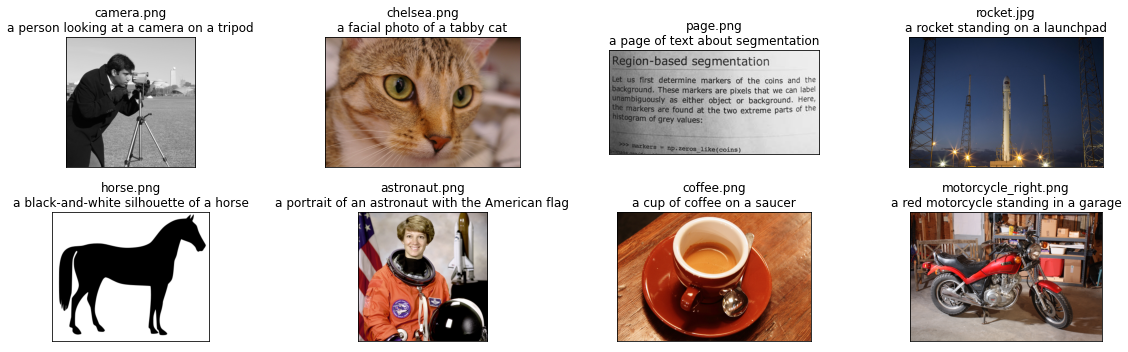

In [10]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
  name = os.path.splitext(filename)[0]
  if name not in descriptions:
    continue
  
  image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

  plt.subplot(2, 4, len(images) + 1)
  plt.imshow(image)
  plt.title(f"{filename}\n{descriptions[name]}")
  plt.xticks([])
  plt.yticks([])

  original_images.append(image)
  images.append(preprocess(image))
  texts.append(descriptions[name])

plt.tight_layout()

## Building features

We normalize the images, tokenize each input text, and run the forward pass of the model to get the image and text features.

In [11]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [12]:
with torch.no_grad():
  image_features = model.encode_image(image_input).float()
  text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [13]:
image_features /= image_features.norm(dim=-1, keepdim= True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

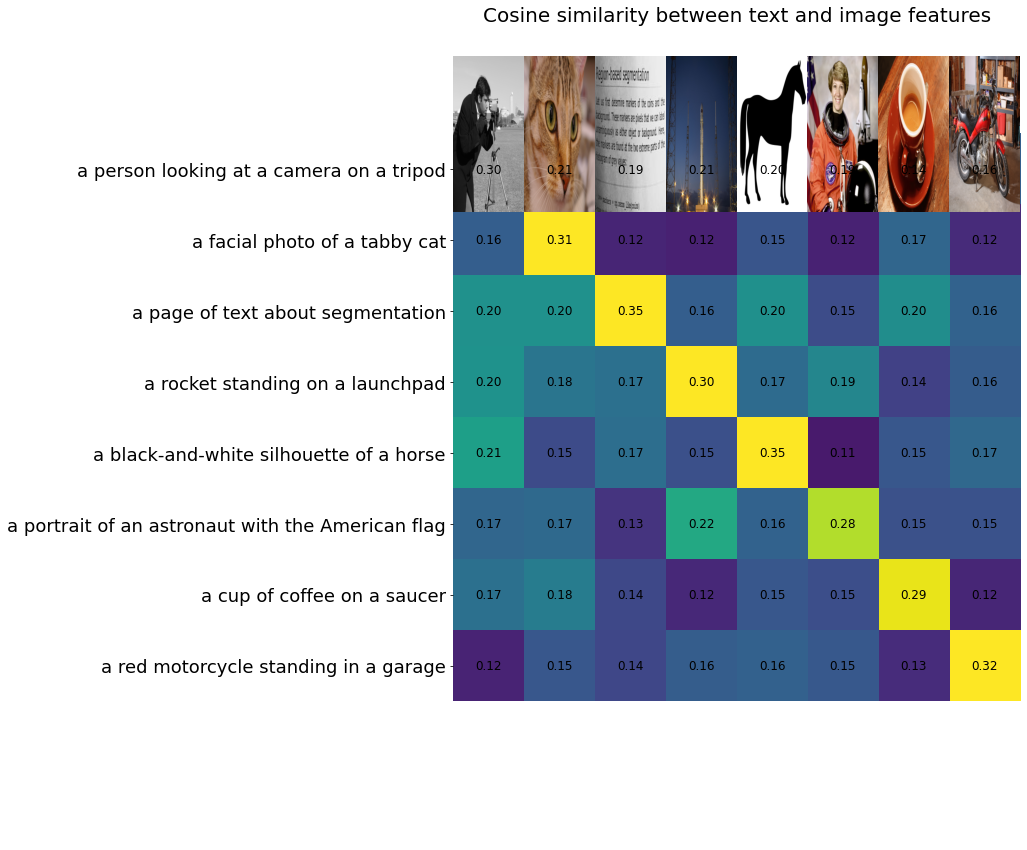

In [26]:
count = len(descriptions)

plt.figure(figsize=(20, 15))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
  plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, 0.6), origin="lower")
for x in range(similarity.shape[1]):
  for y in range(similarity.shape[0]):
    plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

## Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.


In [21]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [22]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes] 
text_tokens = clip.tokenize(text_descriptions).cuda()

In [23]:
with torch.no_grad():
  text_features = model.encode_text(text_tokens).float()
  text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

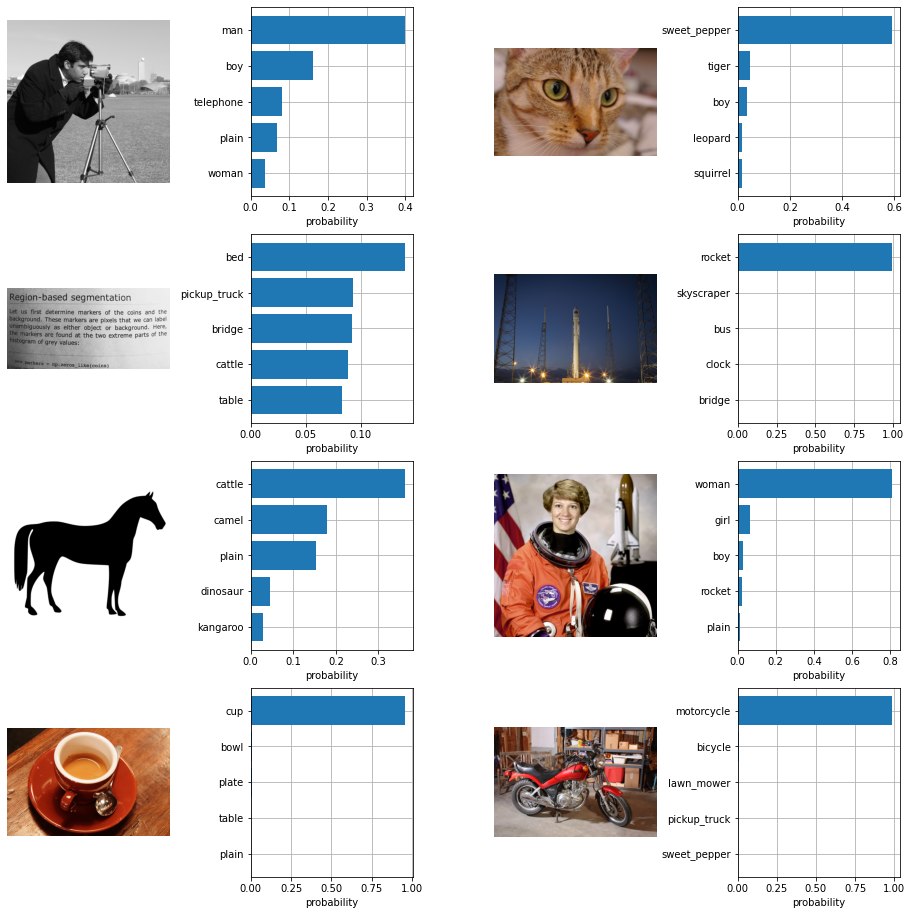

In [25]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
  plt.subplot(4, 4, 2 * i + 1)
  plt.imshow(image)
  plt.axis("off")

  plt.subplot(4, 4, 2 * i+2)
  y = np.arange(top_probs.shape[-1])
  plt.grid()
  plt.barh(y, top_probs[i])
  plt.gca().invert_yaxis()
  plt.gca().set_axisbelow(True)
  plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
  plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

# So far learned from the above tests 

- First we provided images and it's labels using image encoder and text encoder to the model
- Then, we took another dataset for Zero-shot image classification, in which we pulled the classes as our new texts description from new dataset and asked our model to connect the previously given images with new text descriptions.